In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from shapely.geometry import Polygon
import geopandas as gpd

In [3]:
import pickle
import sys
import os
import datetime
import itertools
from tqdm import tqdm_notebook as tqdm
import enum

In [29]:
from ipyleaflet import Map, WMSLayer


In [5]:
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, LoadFromDisk, SaveToDisk, EOExecutor

In [48]:
from eolearn.io import S2L1CWCSInput, ExportToTiff
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector, AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask
from sentinelhub import BBoxSplitter, BBox, CRS, CustomUrlParam, WmsRequest, WcsRequest, MimeType

In [7]:
#from sentinelhub import BBoxSplitter, WmsRequest, WcsRequest, MimeType, CRS, BBox

In [8]:
INSTANCE_ID = 'adba8367-072c-48e8-ae71-cd60dc00ac64'
REQUEST_COUNT = 0

In [34]:
def plot_image(image, factor=1):
    """
    helper to visualize tiles
    """
    fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
    
    if np.issubdtype(image.dtype, np.floating):
        plt.imshow(np.minimum(image * factor, 1))
    else:
        plt.imshow(image)

In [109]:
control_test = Map(center = [-16.15, 46.16], zoom = 11)
control_test

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map data (c) <a href="https://openstreetmap.org">OpenStreetMap</a> contributors'}, center=[-16.15, 46.16], layers=(TileLayer(base=True, max_zoom=19, min_zoom=1, options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'tile_size']),), options=['attribution_control', 'basemap', 'bounce_at_zoom_limits', 'box_zoom', 'center', 'close_popup_on_click', 'double_click_zoom', 'dragging', 'inertia', 'inertia_deceleration', 'inertia_max_speed', 'interpolation', 'keyboard', 'keyboard_pan_offset', 'keyboard_zoom_offset', 'max_zoom', 'min_zoom', 'scroll_wheel_zoom', 'tap', 'tap_tolerance', 'touch_zoom', 'world_copy_jump', 'zoom', 'zoom_animation_threshold', 'zoom_control', 'zoom_start'], zoom=11)

In [136]:
rand_test = Map(center = [-25.81, 28.02], zoom = 14)
#control_test = Map(center = [-16.15, 46.16], zoom = 10)
rand_test

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map data (c) <a href="https://openstreetmap.org">OpenStreetMap</a> contributors'}, center=[-25.81, 28.02], layers=(TileLayer(base=True, max_zoom=19, min_zoom=1, options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'tile_size']),), options=['attribution_control', 'basemap', 'bounce_at_zoom_limits', 'box_zoom', 'center', 'close_popup_on_click', 'double_click_zoom', 'dragging', 'inertia', 'inertia_deceleration', 'inertia_max_speed', 'interpolation', 'keyboard', 'keyboard_pan_offset', 'keyboard_zoom_offset', 'max_zoom', 'min_zoom', 'scroll_wheel_zoom', 'tap', 'tap_tolerance', 'touch_zoom', 'world_copy_jump', 'zoom', 'zoom_animation_threshold', 'zoom_control', 'zoom_start'], zoom=14)

In [137]:
rand_test.bounds

((-25.82546646333619, 27.977886199951172),
 (-25.794559083644042, 28.06217193603516))

In [35]:
#pulled coordinates of a random farm in south africa
noMap_farm = [28.02, -25.81, 28.59,  -25.46]
temp_farm = [46.16, -16.15, 46.51, -15.58]
#[46.16, -16.15, 46.51, -15.58]
#[-25.81, 28.02, -25.46, 28.59]
#[28.02, -25.81, 28.59,  -25.46]
#noMap_bbox = BBox(bbox=rand_farm, crs=CRS.WGS84)
temp_bbox = BBox(bbox=temp_farm, crs=CRS.WGS84)
#control_bbox = BBox(bbox=(control_test.bounds), crs = CRS.WGS84)
#rand_bbox = BBox(bbox=(rand_test.bounds), crs = CRS.WGS84)
rand_arr = [27.34634399414063, -26.05678288577881, 28.69491577148438, -25.562265014427492]
rand_bbox = BBox(bbox=rand_arr, crs=CRS.WGS84)

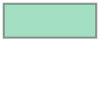

In [36]:
rand_bbox

In [37]:
print(46.51 - 46.16)
print(-15.58 + 16.15)

0.3500000000000014
0.5699999999999985


In [41]:
#rgb
#ndvi_script = 'return [(B05 - B04) / (B05 + B04)]'
#custom_url_params={CustomUrlParam.EVALSCRIPT: ndvi_script},
wms_true_color_request = WmsRequest(layer='TRUE-COLOR-S2-L1C',
                                    bbox= temp_bbox ,
                                    time= 'latest',
                                    
                                    width= 512, height=856,
                                    maxcc = .1,
                                    instance_id=INSTANCE_ID)
wms_true_color_img = wms_true_color_request.get_data() 
REQUEST_COUNT += 1

In [42]:
print(len(wms_true_color_img))

1


rgb output of the random farm


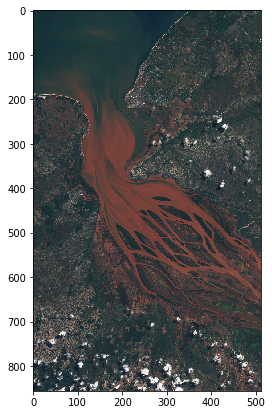

In [43]:
print("rgb output of the random farm")
plot_image(wms_true_color_img[-1])

In [49]:
#bands
wms_bands_request = WmsRequest(layer='BANDS-S2-L1C',
                               bbox=temp_bbox, 
                               time='latest',
                               width=512, height=856,
                               image_format=MimeType.TIFF_d32f,
                               instance_id=INSTANCE_ID)
wms_bands_img = wms_bands_request.get_data()

In [50]:
wms_bands_img[-1][:, :, 12].shape

(856, 512)

In [51]:
def calc_NDVI(bands_request):
    eight = bands_request[-1][:, :, 8]
    four = bands_request[-1][:, :, 4]
    ndvi = eight -four /eight + four
    return ndvi

In [52]:
ndvi.shape

(21, 2112, 1779, 1)

TypeError: Invalid dimensions for image data

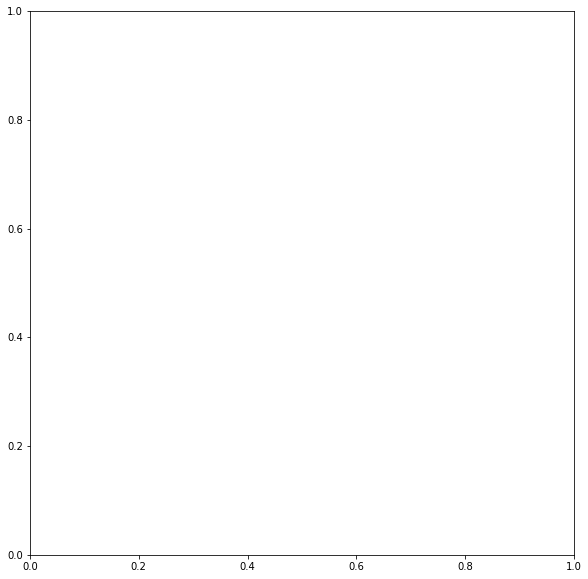

In [53]:
fig = plt.figure(figsize=(10, 10))
fig.set_facecolor('white')
plt.imshow(ndvi) # Typically the color map for NDVI maps are the Red to Yellow to Green
plt.title('NDVI')
plt.show()

In [9]:
class SentinelHubValidData:
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """
    def __call__(self, eopatch):
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool),
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))

class CountValid(EOTask):
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """
    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name

    def execute(self, eopatch):
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.name, np.count_nonzero(eopatch.mask[self.what],axis=0))

        return eopatch


class NormalizedDifferenceIndex(EOTask):
    """
    The tasks calculates user defined Normalised Difference Index (NDI) between two bands A and B as:
    NDI = (A-B)/(A+B).
    """
    def __init__(self, feature_name, band_a, band_b):
        self.feature_name = feature_name
        self.band_a_fetaure_name = band_a.split('/')[0]
        self.band_b_fetaure_name = band_b.split('/')[0]
        self.band_a_fetaure_idx = int(band_a.split('/')[-1])
        self.band_b_fetaure_idx = int(band_b.split('/')[-1])

    def execute(self, eopatch):
        band_a = eopatch.data[self.band_a_fetaure_name][..., self.band_a_fetaure_idx]
        band_b = eopatch.data[self.band_b_fetaure_name][..., self.band_b_fetaure_idx]

        ndi = (band_a - band_b) / (band_a  + band_b)

        eopatch.add_feature(FeatureType.DATA, self.feature_name, ndi[..., np.newaxis])

        return eopatch


class EuclideanNorm(EOTask):
    """
    The tasks calculates Euclidian Norm of all bands within an array:
    norm = sqrt(sum_i Bi**2),
    where Bi are the individual bands within user-specified feature array.
    """
    def __init__(self, feature_name, in_feature_name):
        self.feature_name = feature_name
        self.in_feature_name = in_feature_name

    def execute(self, eopatch):
        arr = eopatch.data[self.in_feature_name]
        norm = np.sqrt(np.sum(arr**2, axis=-1))

        eopatch.add_feature(FeatureType.DATA, self.feature_name, norm[..., np.newaxis])
        return eopatch

Dimension of the area is 1334325 x 1077061 m2


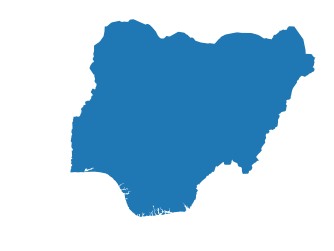

In [10]:
country = gpd.read_file('nigeria.geojson')
# Convert CRS to UTM_33N
country_crs = CRS.UTM_33N
country = country.to_crs(crs={'init': CRS.ogc_string(country_crs)})

# Get the country's shape in polygon format
country_shape = country.geometry.values.tolist()[-1]

# Plot country
country.plot()
plt.axis('off');

# Print size 
print('Dimension of the area is {0:.0f} x {1:.0f} m2'.format(country_shape.bounds[2] - country_shape.bounds[0],
                                                             country_shape.bounds[3] - country_shape.bounds[1]))

In [11]:
use_smaller_patches = True

# Create the splitter to obtain a list of bboxes
bbox_splitter_large = BBoxSplitter([country_shape], country_crs, (25, 17))
bbox_splitter_small = BBoxSplitter([country_shape], country_crs, (25 * 3, 17 * 3))

bbox_splitter = bbox_splitter_small if use_smaller_patches else bbox_splitter_large

bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

# For the future examples, we will be using a specific set of patches,
# but you are free to change the patch ID numbers in the scope of this example
# Select a central patch
ID = 759 if use_smaller_patches else 190 

# Obtain surrounding patches
patchIDs = []
for idx, [bbox, info] in enumerate(zip(bbox_list, info_list)):
    if (abs(info['index_x'] - info_list[ID]['index_x']) <= 1 and
        abs(info['index_y'] - info_list[ID]['index_y']) <= 1):
        patchIDs.append(idx)

# Check if final size is 3x3
if len(patchIDs) != 9:
    print('Warning! Use a different central patch ID, this one is on the border.')
    
# Change the order of the patches (used for plotting later)
patchIDs = np.transpose(np.fliplr(np.array(patchIDs).reshape(3, 3))).ravel()
    
# Prepare info of selected EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list[patchIDs]]
idxs_x = [info['index_x'] for info in info_list[patchIDs]]
idxs_y = [info['index_y'] for info in info_list[patchIDs]]
df = pd.DataFrame({'index_x': idxs_x, 'index_y': idxs_y})
gdf = gpd.GeoDataFrame(df, 
                       crs={'init': CRS.ogc_string(country_crs)}, 
                       geometry=geometry)

# save to shapefile
shapefile_name = './selected_3x3_bboxes_slovenia_small.shp' if use_smaller_patches \
    else './selected_3x3_bboxes_slovenia_large.shp'
gdf.to_file(shapefile_name)

In [12]:
poly = gdf['geometry'][0]
x1, y1, x2, y2 = poly.bounds
aspect_ratio = (y1 - y2) / (x1 - x2)

# content of the geopandas dataframe
gdf.head()

index_x  index_y                                           geometry
0       20       23  POLYGON ((-514413.3900311765 963700.2382578963...
1       21       23  POLYGON ((-496622.3884934132 963700.2382578963...
2       22       23  POLYGON ((-478831.3869556499 963700.2382578963...
3       20       22  POLYGON ((-514413.3900311765 942581.389565673,...
4       21       22  POLYGON ((-496622.3884934132 942581.389565673,...

In [ ]:
gdf

(-936949.6765530552, 530807.9503124177, 424113.6541715886, 1608881.0658053213)

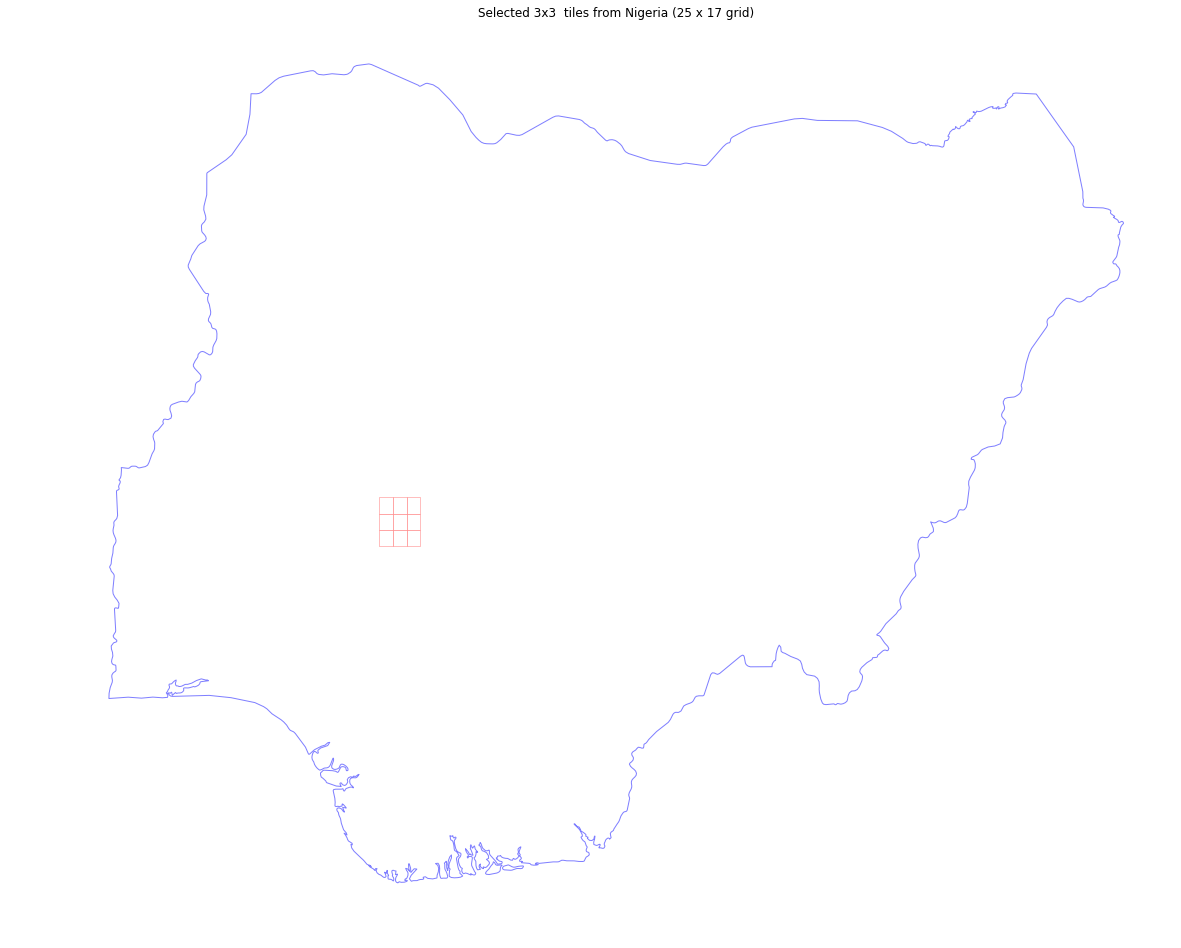

In [13]:

fontdict = {'family': 'monospace', 'weight': 'normal', 'size': 11}

# if bboxes have all same size, estimate offset
xl, yl, xu, yu = gdf.geometry[0].bounds
xoff, yoff = (xu - xl) / 3, (yu - yl) / 5

# figure
fig, ax = plt.subplots(figsize=(20, 20))
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
country.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
ax.set_title('Selected 3x3  tiles from Nigeria (25 x 17 grid)');
plt.axis('off')



In [14]:
custom_script = 'return [B02, B03, B04, B08, B11, B12];'
add_data = S2L1CWCSInput(
    layer='BANDS-S2-L1C',
    feature=(FeatureType.DATA, 'BANDS'), # save under name 'BANDS'
    custom_url_params={CustomUrlParam.EVALSCRIPT: custom_script}, # custom url for 6 specific bands
    resx='10m', # resolution x
    resy='10m', # resolution y
    maxcc=0.2, # maximum allowed cloud cover of original ESA tiles
    instance_id = INSTANCE_ID
)
ndvi = NormalizedDifferenceIndex('NDVI', 'BANDS/3', 'BANDS/2')

In [15]:
# TASK FOR CLOUD INFO
# cloud detection is performed at 80m resolution
# and the resulting cloud probability map and mask
# are scaled to EOPatch's resolution
cloud_classifier = get_s2_pixel_cloud_detector(average_over=2, dilation_size=1, all_bands=False)
add_clm = AddCloudMaskTask(cloud_classifier, 'BANDS-S2CLOUDLESS', cm_size_y='80m', cm_size_x='80m',
                           cmask_feature='CLM', # cloud mask name
                           cprobs_feature='CLP', # cloud prob. map name
                           instance_id = INSTANCE_ID
                          )

# TASKS FOR CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# NORM: sqrt(B02^2 + B03^2 + B04^2 + B08^2 + B11^2 + B12^2)
ndvi = NormalizedDifferenceIndex('NDVI', 'BANDS/3', 'BANDS/2')
ndwi = NormalizedDifferenceIndex('NDWI', 'BANDS/1', 'BANDS/3')
norm = EuclideanNorm('NORM','BANDS')

# TASK FOR VALID MASK
# validate pixels using SentinelHub's cloud detection mask and region of acquisition
add_sh_valmask = AddValidDataMaskTask(SentinelHubValidData(),
                                      'IS_VALID' # name of output mask
                                     )

# TASK FOR COUNTING VALID PIXELS
# count number of valid observations per pixel using valid data mask
count_val_sh = CountValid('IS_VALID', # name of existing mask
                          'VALID_COUNT' # name of output scalar
                         )

In [16]:
path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'
if not os.path.isdir(path_out):
    os.makedirs(path_out)
save = SaveToDisk(path_out, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [17]:
class LULC(enum.Enum):
    NO_DATA            = (0,  'No Data',            'white')
    CULTIVATED_LAND    = (1,  'Cultivated Land',    'xkcd:lime')
    FOREST             = (2,  'Forest',             'xkcd:darkgreen')
    GRASSLAND          = (3,  'Grassland',          'orange')
    SHRUBLAND          = (4,  'Shrubland',          'xkcd:tan')
    WATER              = (5,  'Water',              'xkcd:azure')
    WETLAND            = (6,  'Wetlands',           'xkcd:lightblue')
    TUNDRA             = (7,  'Tundra',             'xkcd:lavender')
    ARTIFICIAL_SURFACE = (8,  'Artificial Surface', 'crimson')
    BARELAND           = (9,  'Bareland',           'xkcd:beige')
    SNOW_AND_ICE       = (10, 'Snow and Ice',       'black')

    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3

# example usecase
# LULC.BARELAND.id   # return 9

# Reference colormap things
lulc_cmap = mpl.colors.ListedColormap([entry.color for entry in LULC])
lulc_norm = mpl.colors.BoundaryNorm(np.arange(-0.5, 11, 1), lulc_cmap.N)

In [18]:
workflow = LinearWorkflow(
    add_data,
    add_clm,
    ndvi,
    ndwi,
    norm,
    add_sh_valmask,
    count_val_sh,
    save
)

In [20]:
time_interval = ['2017-01-01', '2017-12-31'] # time interval for the SH request

# Show progress bar
pbar = tqdm(total=len(patchIDs))
#print(patchIDs)
for idx, bbox in enumerate(bbox_list[patchIDs]):

    # define additional parameters of the workflow
    extra_param = {
        add_data:{'bbox': bbox, 'time_interval': time_interval},
        save: {'eopatch_folder': 'eopatch_{}'.format(idx)}
    }

    workflow.execute(extra_param)
    pbar.update(1)

HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in sqrt


In [21]:
EOPatch.load('./eopatches_small/eopatch_0/')

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(18, 2112, 1779, 6), dtype=float32)
    CLP: numpy.ndarray(shape=(18, 2112, 1779, 1), dtype=float32)
    NDVI: numpy.ndarray(shape=(18, 2112, 1779, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(18, 2112, 1779, 1), dtype=float32)
    NORM: numpy.ndarray(shape=(18, 2112, 1779, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(18, 2112, 1779, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(18, 2112, 1779, 1), dtype=bool)
    IS_VALID: numpy.ndarray(shape=(18, 2112, 1779, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    VALID_COUNT: numpy.ndarray(shape=(2112, 1779, 1), dtype=int64)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.2
    service_type: 'wcs'
    size_x: '10m'
    size_y: '10m'
    time_difference: datetime.timedelta(-1, 86399)
    time_interval: ['2017-01-01', '2017-12-31']
  }
  bbox: BBox(((-514413.390031176

In [22]:
patches = []

HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

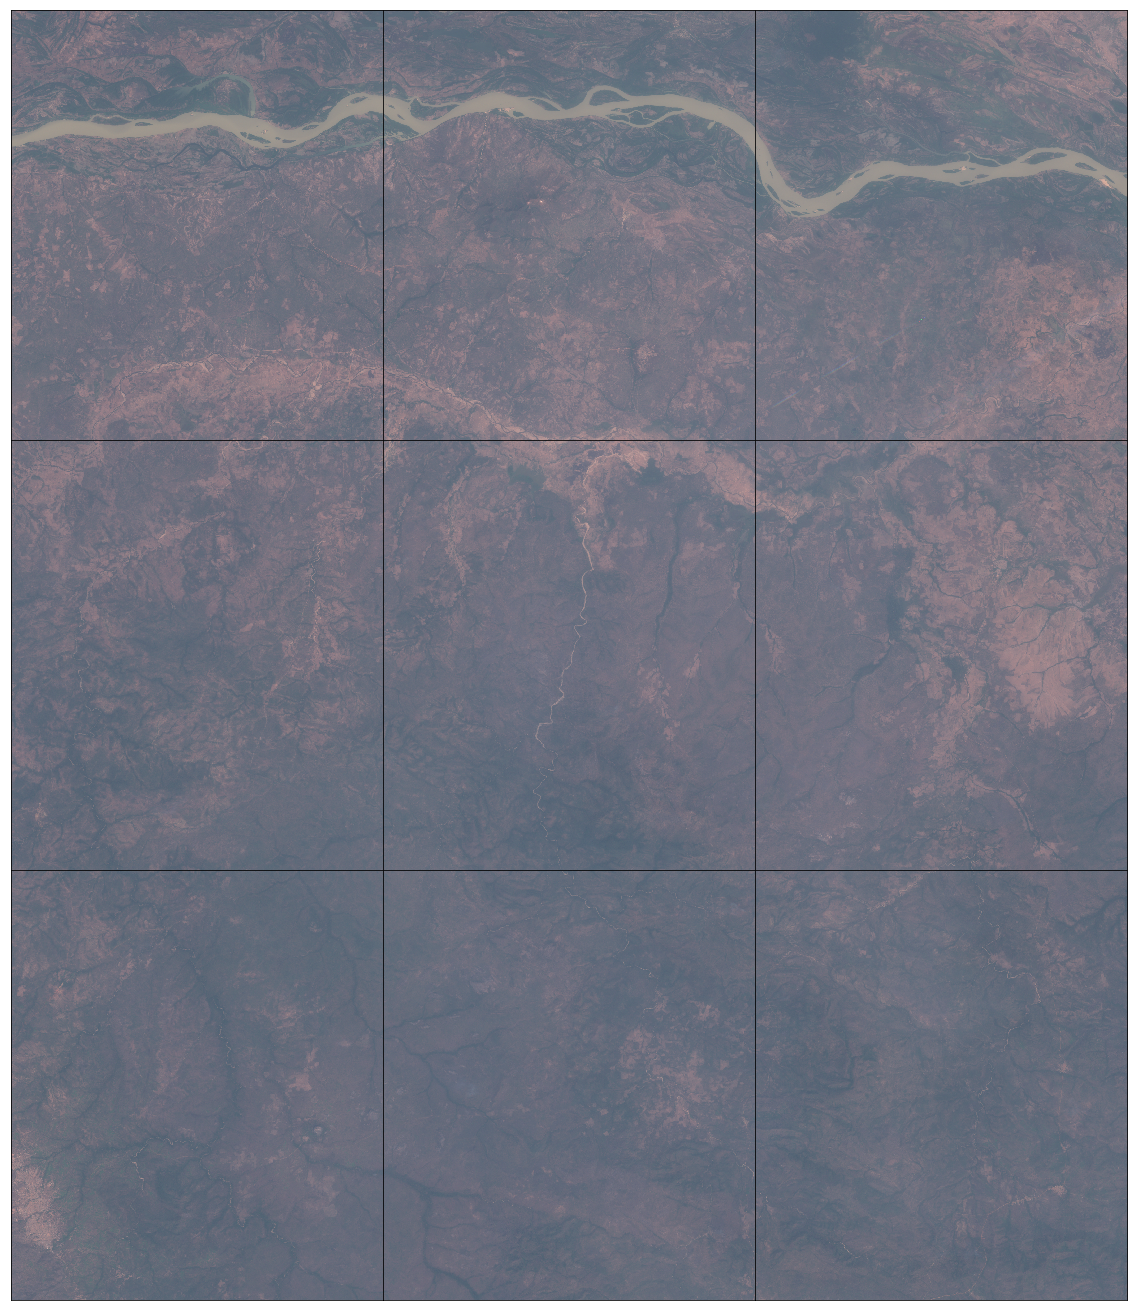

In [23]:
path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'
fig = plt.figure(figsize=(20, 20 * aspect_ratio))

pbar = tqdm(total=9)
for i in range(9):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, i), lazy_loading=True)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.clip(eopatch.data['BANDS'][0][..., [2, 1, 0]] * 3.5, 0, 1))
    plt.xticks([])
    plt.yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    #patches = np.append(patches, [eopatch.data['NDVI']])
    patches.append(eopatch.data['NDVI'])
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

In [24]:
eID = 1
eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, eID), lazy_loading=True)

ndvi = eopatch.data['NDVI'] # ndvi data cube
len(ndvi)

18

HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

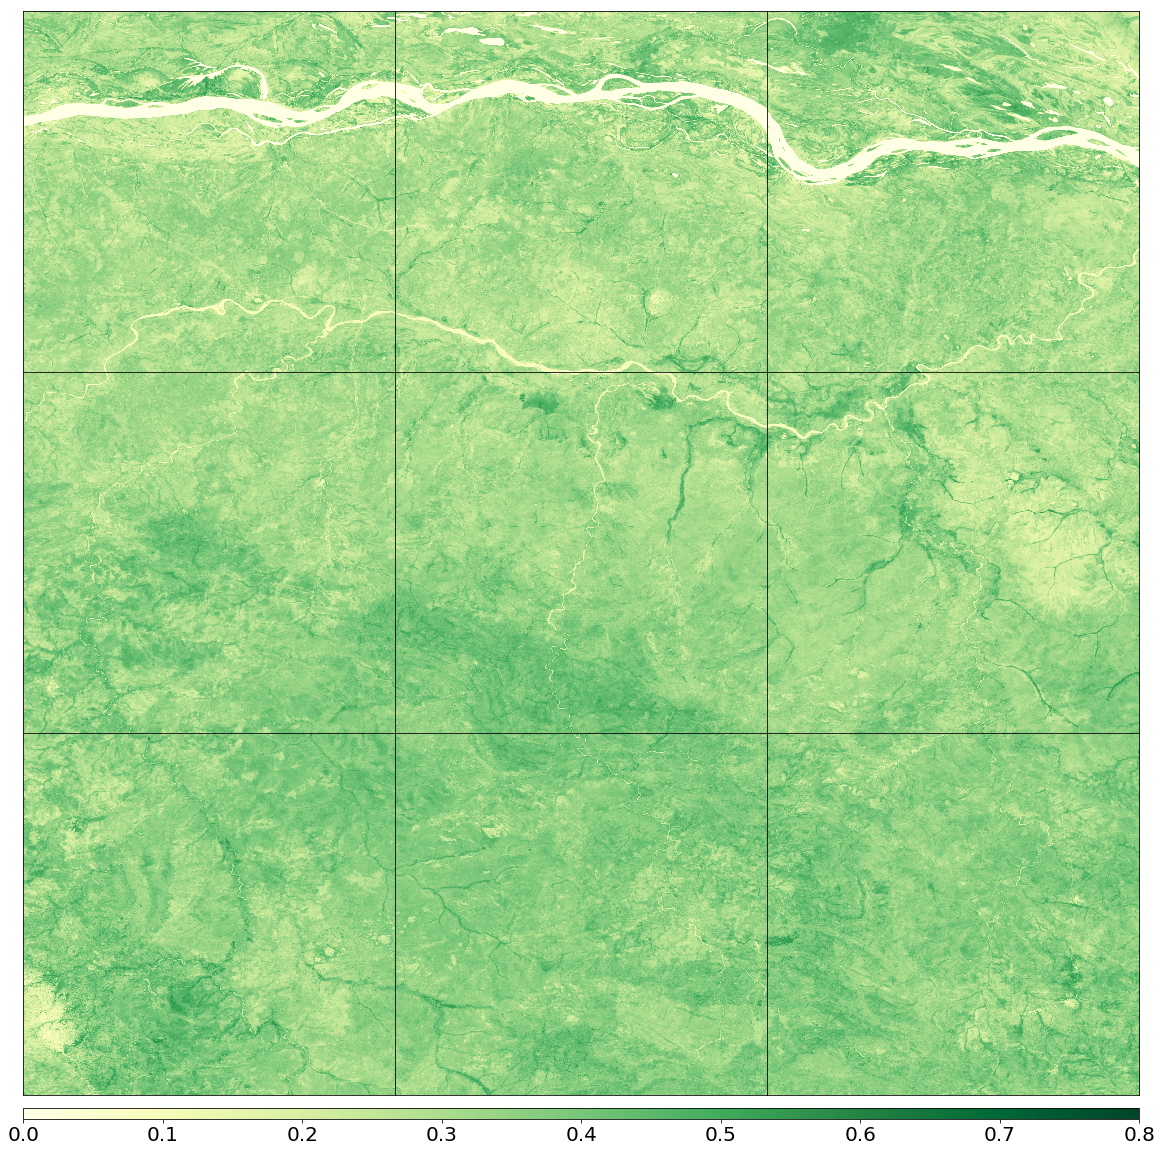

In [25]:
path_out = './eopatches_small/' if use_smaller_patches else './eopatches_large/'

fig, axes = plt.subplots(figsize=(20, 20 * aspect_ratio), nrows=3, ncols=3)
    
pbar = tqdm(total=9)
for i, ax in enumerate(axes.flat):
    eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, i), lazy_loading=True)
    ndvi = eopatch.data['NDVI']
    mask = eopatch.mask['IS_VALID']
    ndvi[~mask] = np.nan
    ndvi_mean = np.nanmean(ndvi, axis=0).squeeze()
    im = ax.imshow(ndvi_mean, vmin=0, vmax=0.8, cmap=plt.get_cmap('YlGn'))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    pbar.update(1)
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20) 
plt.show()

In [ ]:
#with open('outfile.txt', 'wb') as fp:
 #   pickle.dump(patches, fp)

In [ ]:
with open('outfile2.txt', 'wb') as fp:
    pickle.dump(patches[0], fp)

TypeError: 'tuple' object is not callable